<h1 style="text-align: center;">Working with DataFrame. Data processing. Regression</h1>

###### -- Install necessary libraries: scikit-learn, Pandas, NumPy, Matplotlib, Seaborn etc

In [1]:
# importing libraries to work with dataframe (pandas) and numerical operations (numpy)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

###### -- Use pd.read_csv() to read median-price-dataset.csv.

In [2]:
df = pd.read_csv("data/median-price-dataset.csv")
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
0            NEAR BAY  
1            NEAR BAY  
2            NEAR BAY  
3            NEAR BAY  
4            NEAR BAY  
...               ...  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAND  
20639          INLAND  

[20640 rows x 10 columns]

###### -- Data Preprocessing
- Handling Missing Data
  - Identify and handle missing values
- Feature Engineering
  - Explore and create new features if necessary
  - Feature scaling

In [24]:
# checking if there's any missing values
print(df.isnull().sum())

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms         0
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
rooms_per_household    0
dtype: int64


In [4]:
# handling missing data using custom method of fuzzy spatial extrapolation

def fuzzy_spatial_extrapolation(df, target_column_name):
    # searching for indices with missing values and without missing values
    missing_indices = df[df[target_column_name].isnull()].index
    non_missing_indices = df.dropna(subset=[target_column_name]).index
    # stating which column is without missing values
    columns_non_missing = df.columns.difference([target_column_name])
    # calculating number of numeric columns for normalization
    numeric_columns = df._get_numeric_data().columns
    num_columns = len(numeric_columns)
    
    for target_index in missing_indices:
        # data to calculate the distance
        data_for_distance = df.loc[non_missing_indices, numeric_columns]
        # calculating the abs of differences between the patient with a gap and other patients
        absolute_diff = data_for_distance.sub(
            df.loc[target_index, numeric_columns], axis=1
        ).abs()
        # the sum of absolute differences normalized by the columns num
        similarities = absolute_diff.sum(axis=1) / num_columns
        # inverse similarities
        inverse_similarities = np.reciprocal(similarities + 1e-10)  # Avoid division by zero
        # normalizing inverse similarities to vary between 0 and 1
        normalized_similarities = inverse_similarities / np.sum(inverse_similarities)
        # membership degree as normalized inverse similarities
        membership_degree = normalized_similarities
        # calculating the missing value using a weighted average
        new_value = np.sum(df.loc[non_missing_indices, target_column_name] * membership_degree)
        # filling the gap
        df.at[target_index, target_column_name] = new_value

    return df

# dropping columns with more than 20% gaps
columns_to_drop = df.columns[df.isnull().mean() > 0.2]
df = df.drop(columns=columns_to_drop)

# determining columns with gaps in the remaining DataFrame
columns_with_nan = df.columns[df.isnull().any()]

# filling in the columns with a custom method of fuzzy spatial extrapolation
for column in columns_with_nan:
    fuzzy_spatial_extrapolation(df, column)

df


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
0            NEAR BAY  
1            NEAR BAY  
2            NEAR BAY  
3            NEAR BAY  
4            NEAR BAY  
...               ...  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAND  
20639          INLAND  

[20640 rows x 10 columns]

In [5]:
# checking if there're any missing values after imputation
print(df.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


There is no more missing values, so the next stage could be done.

Let’s plot the distribution of the target variable median_house_value with the histplot.

C:\Users\igor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\igor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


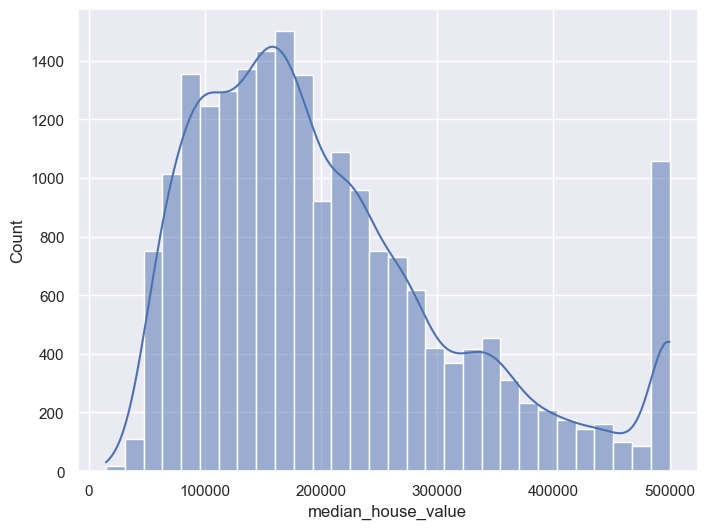

In [6]:
sns.set(rc={'figure.figsize':(8,6)})
sns.histplot(df['median_house_value'], bins=30, kde=True)
plt.show()

We see that the values of median_house_value are distributed normally with few outliers.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# ocean_poximity is a categorical variable 
# which is not suitable for scailing, so we have to encode it
df['ocean_proximity'] = label_encoder.fit_transform(df['ocean_proximity'].values)

# displaying the mapping between original categories and numerical labels
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping between original categories and numerical labels:")
print(mapping)

Mapping between original categories and numerical labels:
{'<1H OCEAN': 0, 'INLAND': 1, 'ISLAND': 2, 'NEAR BAY': 3, 'NEAR OCEAN': 4}


In [9]:
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity  
0                    3  
1                    3  
2                    3  
3                    3  
4                    3  
...                ...  
20635                1  
20636                1  
20637                1  
20638                1  
20639                1  

[20640 rows x 10 columns]

In [10]:
# explore and create new features if necessary
# let's create a new feature 'rooms_per_household' which divides total_rooms by households
df['rooms_per_household'] = df['total_rooms'] / df['households']
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity  rooms_per_household  
0                    3             6.984127  
1                    3             6.238137  
2                    3             8.288136  
3                    3             5.817352  
4                    3             6.281853  
...                ...                  ...  
20635                1             5.045455  
20636                1             6.114035  
20637                1             5.205543  
20638                1             5.329513  
20639                1             5.254717  

[20640 rows x 11 columns]

In [11]:
from sklearn.preprocessing import StandardScaler

# separating features and target variable for scaling
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(pd.DataFrame(X_scaled, columns=X.columns).head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -1.327835  1.052548            0.982143    -0.804819       -0.974347   
1  -1.322844  1.043185           -0.607019     2.045890        1.355736   
2  -1.332827  1.038503            1.856182    -0.535746       -0.828866   
3  -1.337818  1.038503            1.856182    -0.624215       -0.721543   
4  -1.337818  1.038503            1.856182    -0.462404       -0.614221   

   population  households  median_income  ocean_proximity  rooms_per_household  
0   -0.974429   -0.977033       2.344766         1.291089             0.628559  
1    0.861439    1.669961       2.332238         1.291089             0.327041  
2   -0.820777   -0.843637       1.782699         1.291089             1.155620  
3   -0.766028   -0.733781       0.932968         1.291089             0.156966  
4   -0.759847   -0.629157      -0.012881         1.291089             0.344711  


###### -- Exploratory Data Analysis (EDA)

- Visualizing Data
  - Use Matplotlib and Seaborn for data visualization
  - Understand relationships between features and the target variable
  - Visualize data using PCA or TSNE
- Data Preparation
  - Divide the dataset into training and testing sets

Let's create a correlation matrix to measure the linear relationships between the variables to determine which variables correlate with the target variable.

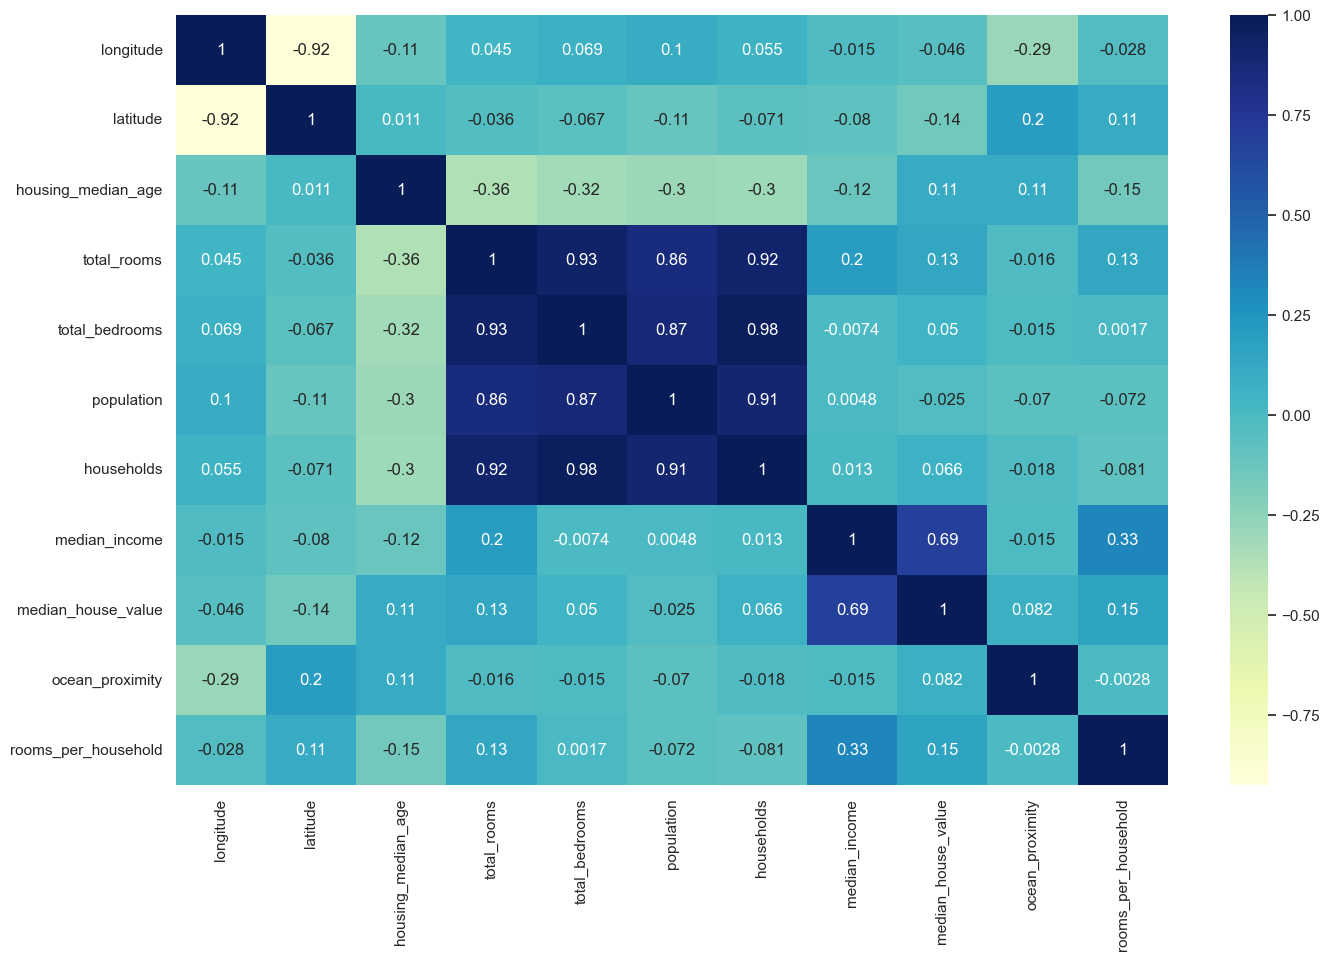

In [12]:
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

By looking at the correlation matrix we can see that median_income has a strong positive correlation with median_house_value (0.69). 

Using a pairplot plot let’s see how this feature vary with median_house_value.

C:\Users\igor\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


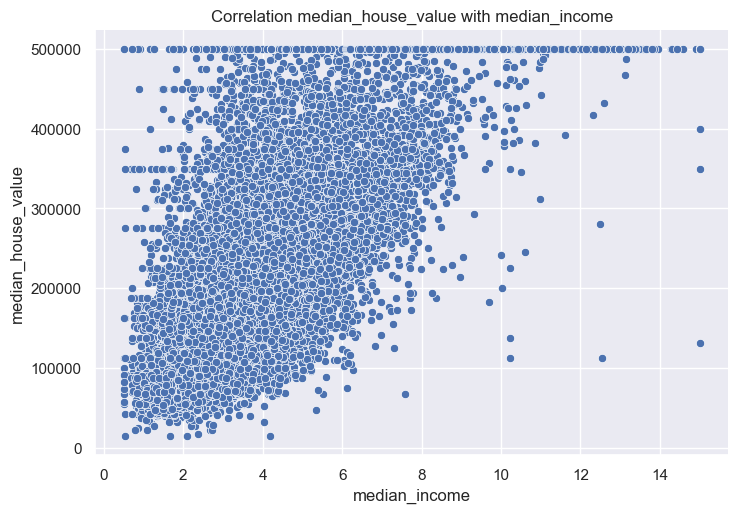

In [13]:
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated")
sns.pairplot(df, x_vars=['median_income'], y_vars=['median_house_value'], height=5, aspect=1.5)
plt.title('Correlation median_house_value with median_income')
plt.show()


Using a pairplot plot let’s see how all of our features vary with median_income.

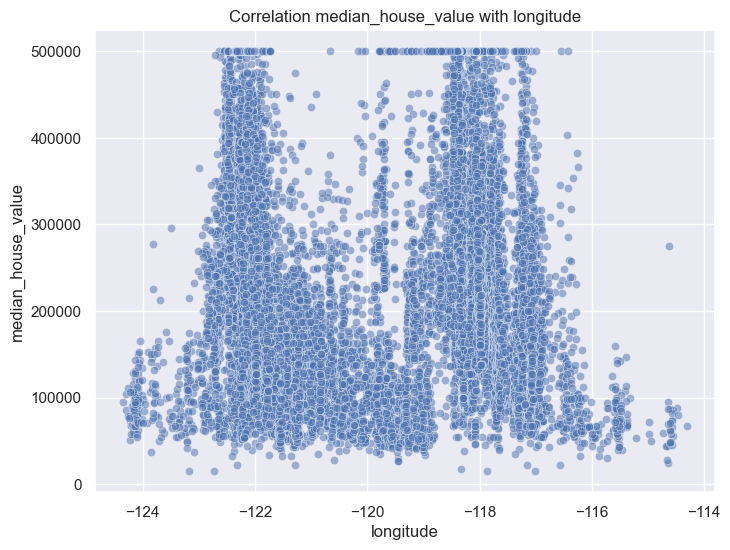

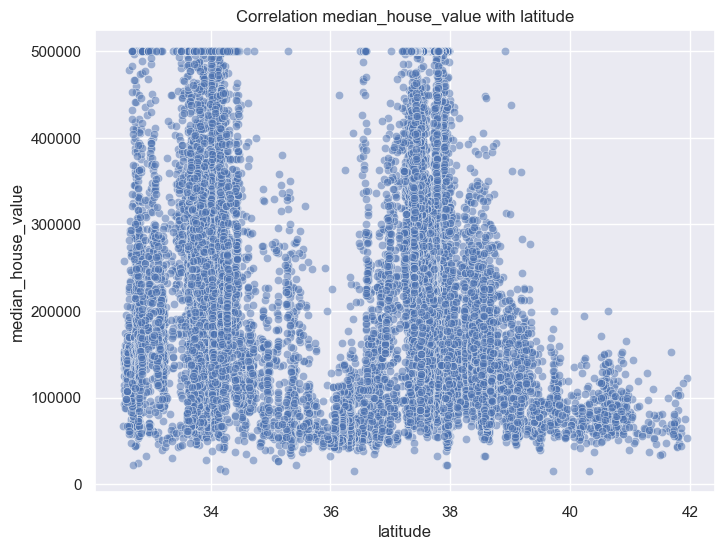

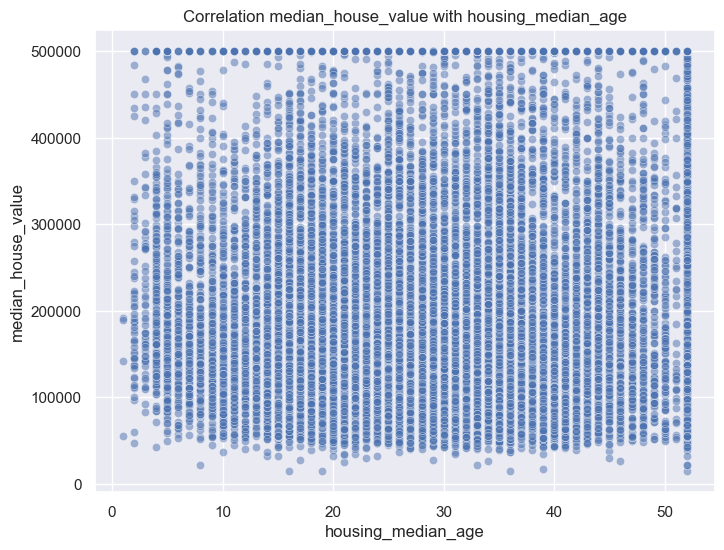

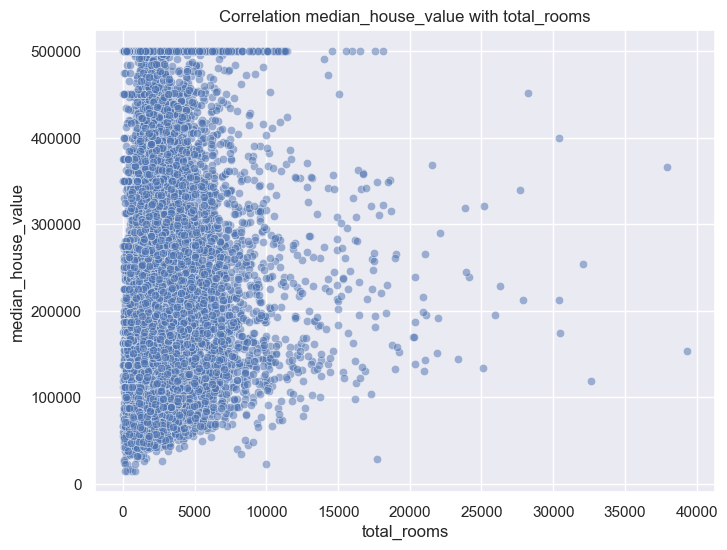

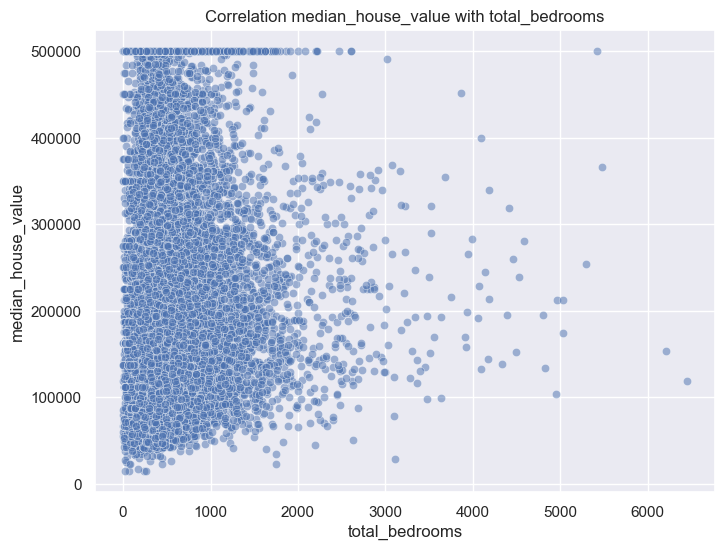

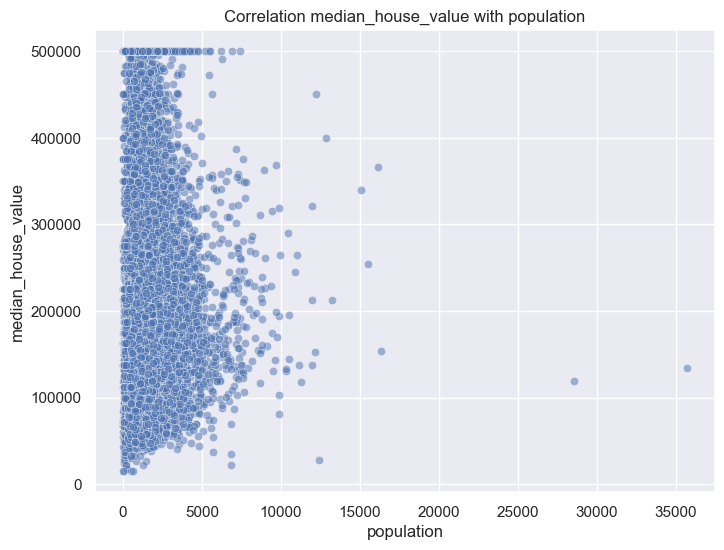

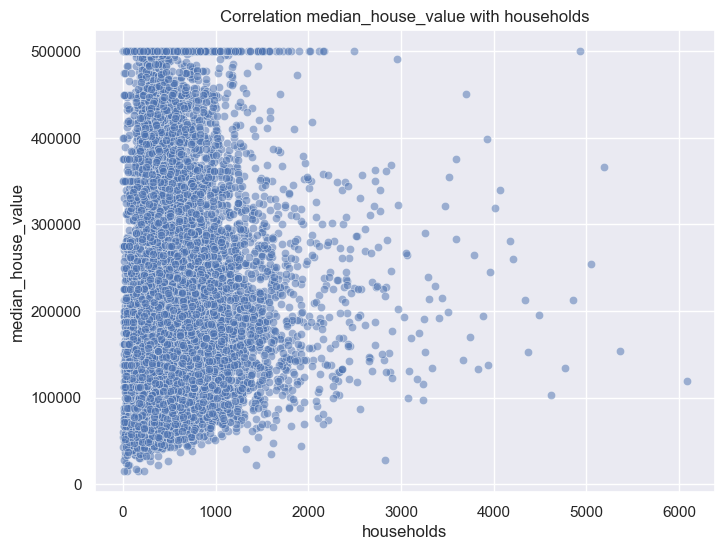

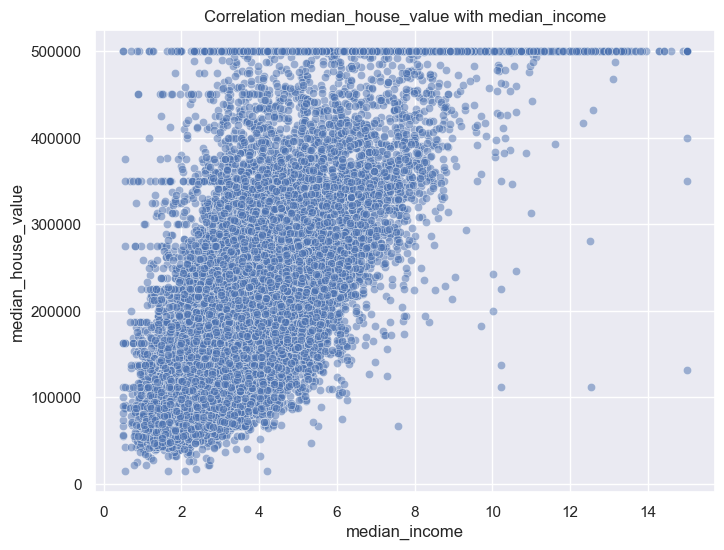

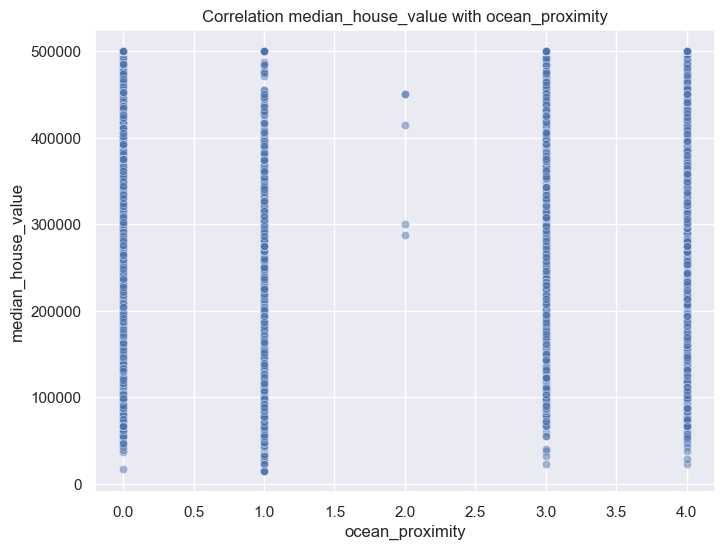

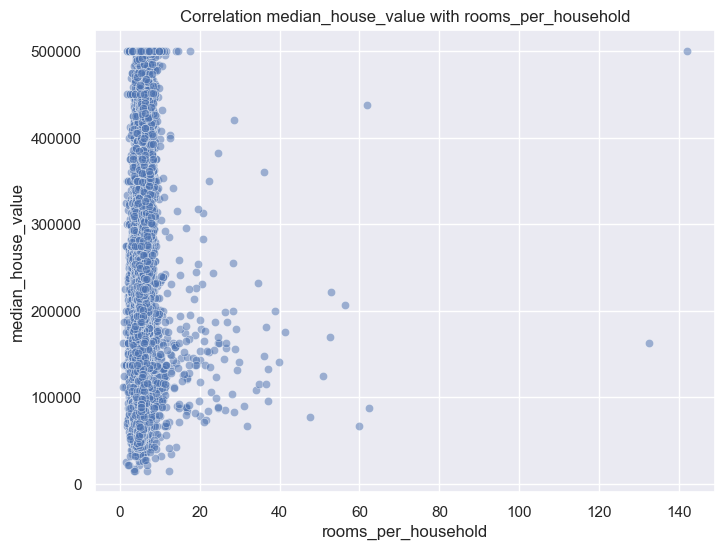

In [14]:
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated")
for column in X.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=column, y='median_house_value', alpha=0.5)
    plt.title(f'Correlation median_house_value with {column}')
    plt.show()

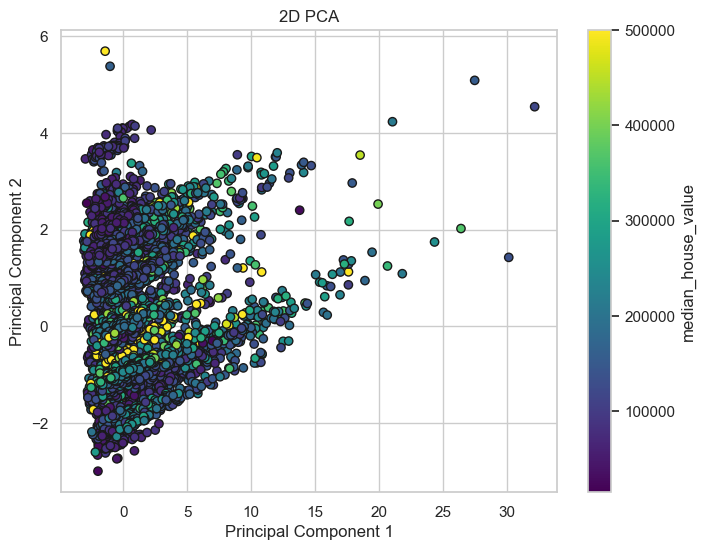

In [15]:
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

# visualizing data using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('2D PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='median_house_value')
plt.show()


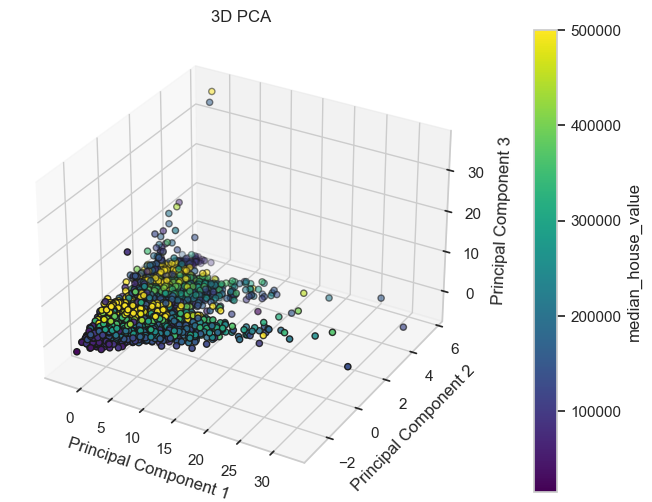

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# visualizing data using PCA
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_3d = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis', edgecolor='k')
ax.set_title('3D PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
cbar = plt.colorbar(scatter_3d, ax=ax, pad=0.1)
cbar.set_label('median_house_value')
plt.show()

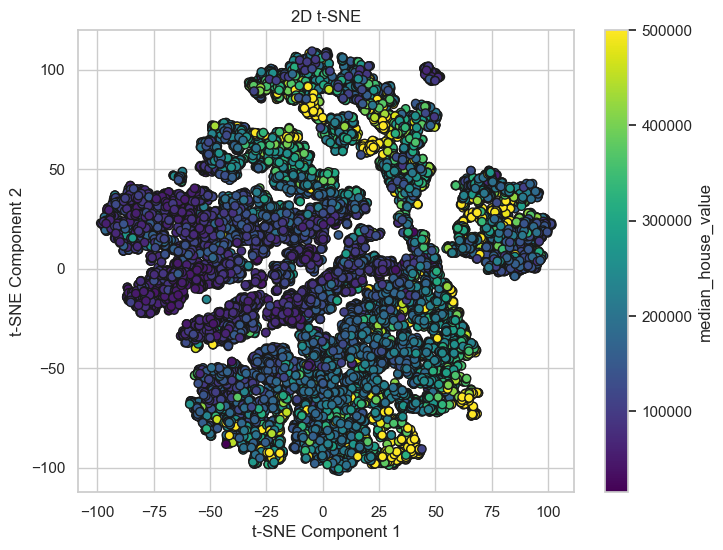

In [17]:
from sklearn.manifold import TSNE

# visualizing data using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('2D t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='median_house_value')
plt.show()

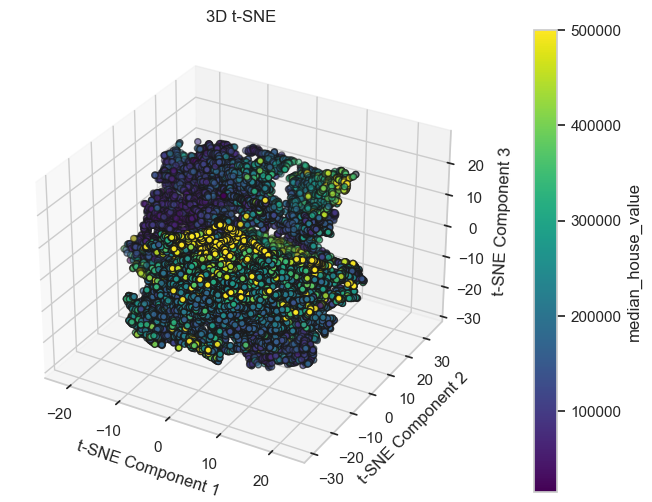

In [18]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# visualizing data using t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_tsne_3d = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y, cmap='viridis', edgecolor='k')
ax.set_title('3D t-SNE')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
cbar_tsne = plt.colorbar(scatter_tsne_3d, ax=ax, pad=0.1)
cbar_tsne.set_label('median_house_value')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split

# dividing the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (14448, 10)
Shape of X_test: (6192, 10)
Shape of y_train: (14448,)
Shape of y_test: (6192,)


###### -- Build and Train Models
- Linear Regression
	- Implementing linear regression in scikit-learn
- Decision Tree Regression
	- Implementing decision tree regression
- Random Forest Regression
	- Implementing Random Forest regression
- XGBoost Regression
	- Implementing XGBoost regression(for this from xgboost import XGBRegressor)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression':  RandomForestRegressor(),
    'XGBoost Regression': XGBRegressor()
}

fitted_models = {}
for name, model in models.items():
    fitted_model = model.fit(X_train, y_train)
    fitted_models[name] = {'model': fitted_model, 'original_model': model}


###### 6. Model Evaluation

- Metrics for Regression Models (from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error)
	- Mean Squared Error (MSE)
	- Mean Absolute Error (MAPE)
	- Mean Absolute Percentage Error (MAPE)
	- R-squared
- Interpret your results

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

data = []

# training and evaluating models
for name, model_info in fitted_models.items():
    
    model = model_info['model']
    
    # predicting on the training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluating the model on training set
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    # evaluating the model on test set
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    data.append({
        'Model': name,
        'MSE Train': mse_train,
        'MSE Test': mse_test,
        'MAE Train': mae_train,
        'MAE Test': mae_test,
        'MAPE Train': mape_train,
        'MAPE Test': mape_test,
        'R2 Train': r2_train,
        'R2 Test': r2_test
    })

results_df = pd.DataFrame(data)
results_df.set_index('Model', inplace=True)
results_df

MSE Train      MSE Test     MAE Train  \
Model                                                                
Linear Regression         4.846267e+09  4.817019e+09  50808.843421   
Decision Tree Regression  0.000000e+00  4.870842e+09      0.000000   
Random Forest Regression  3.549597e+08  2.488977e+09  12186.608774   
XGBoost Regression        7.334066e+08  2.316523e+09  19268.883732   

                              MAE Test  MAPE Train  MAPE Test  R2 Train  \
Model                                                                     
Linear Regression         50897.410791    0.303000   0.305005  0.638256   
Decision Tree Regression  44165.190891    0.000000   0.236774  1.000000   
Random Forest Regression  32248.429097    0.067062   0.180365  0.973504   
XGBoost Regression        31987.589143    0.110110   0.180470  0.945256   

                           R2 Test  
Model                               
Linear Regression         0.633000  
Decision Tree Regression  0.628900  
Random Forest Regression  0.810369  
XGBoost Regression        0.823508

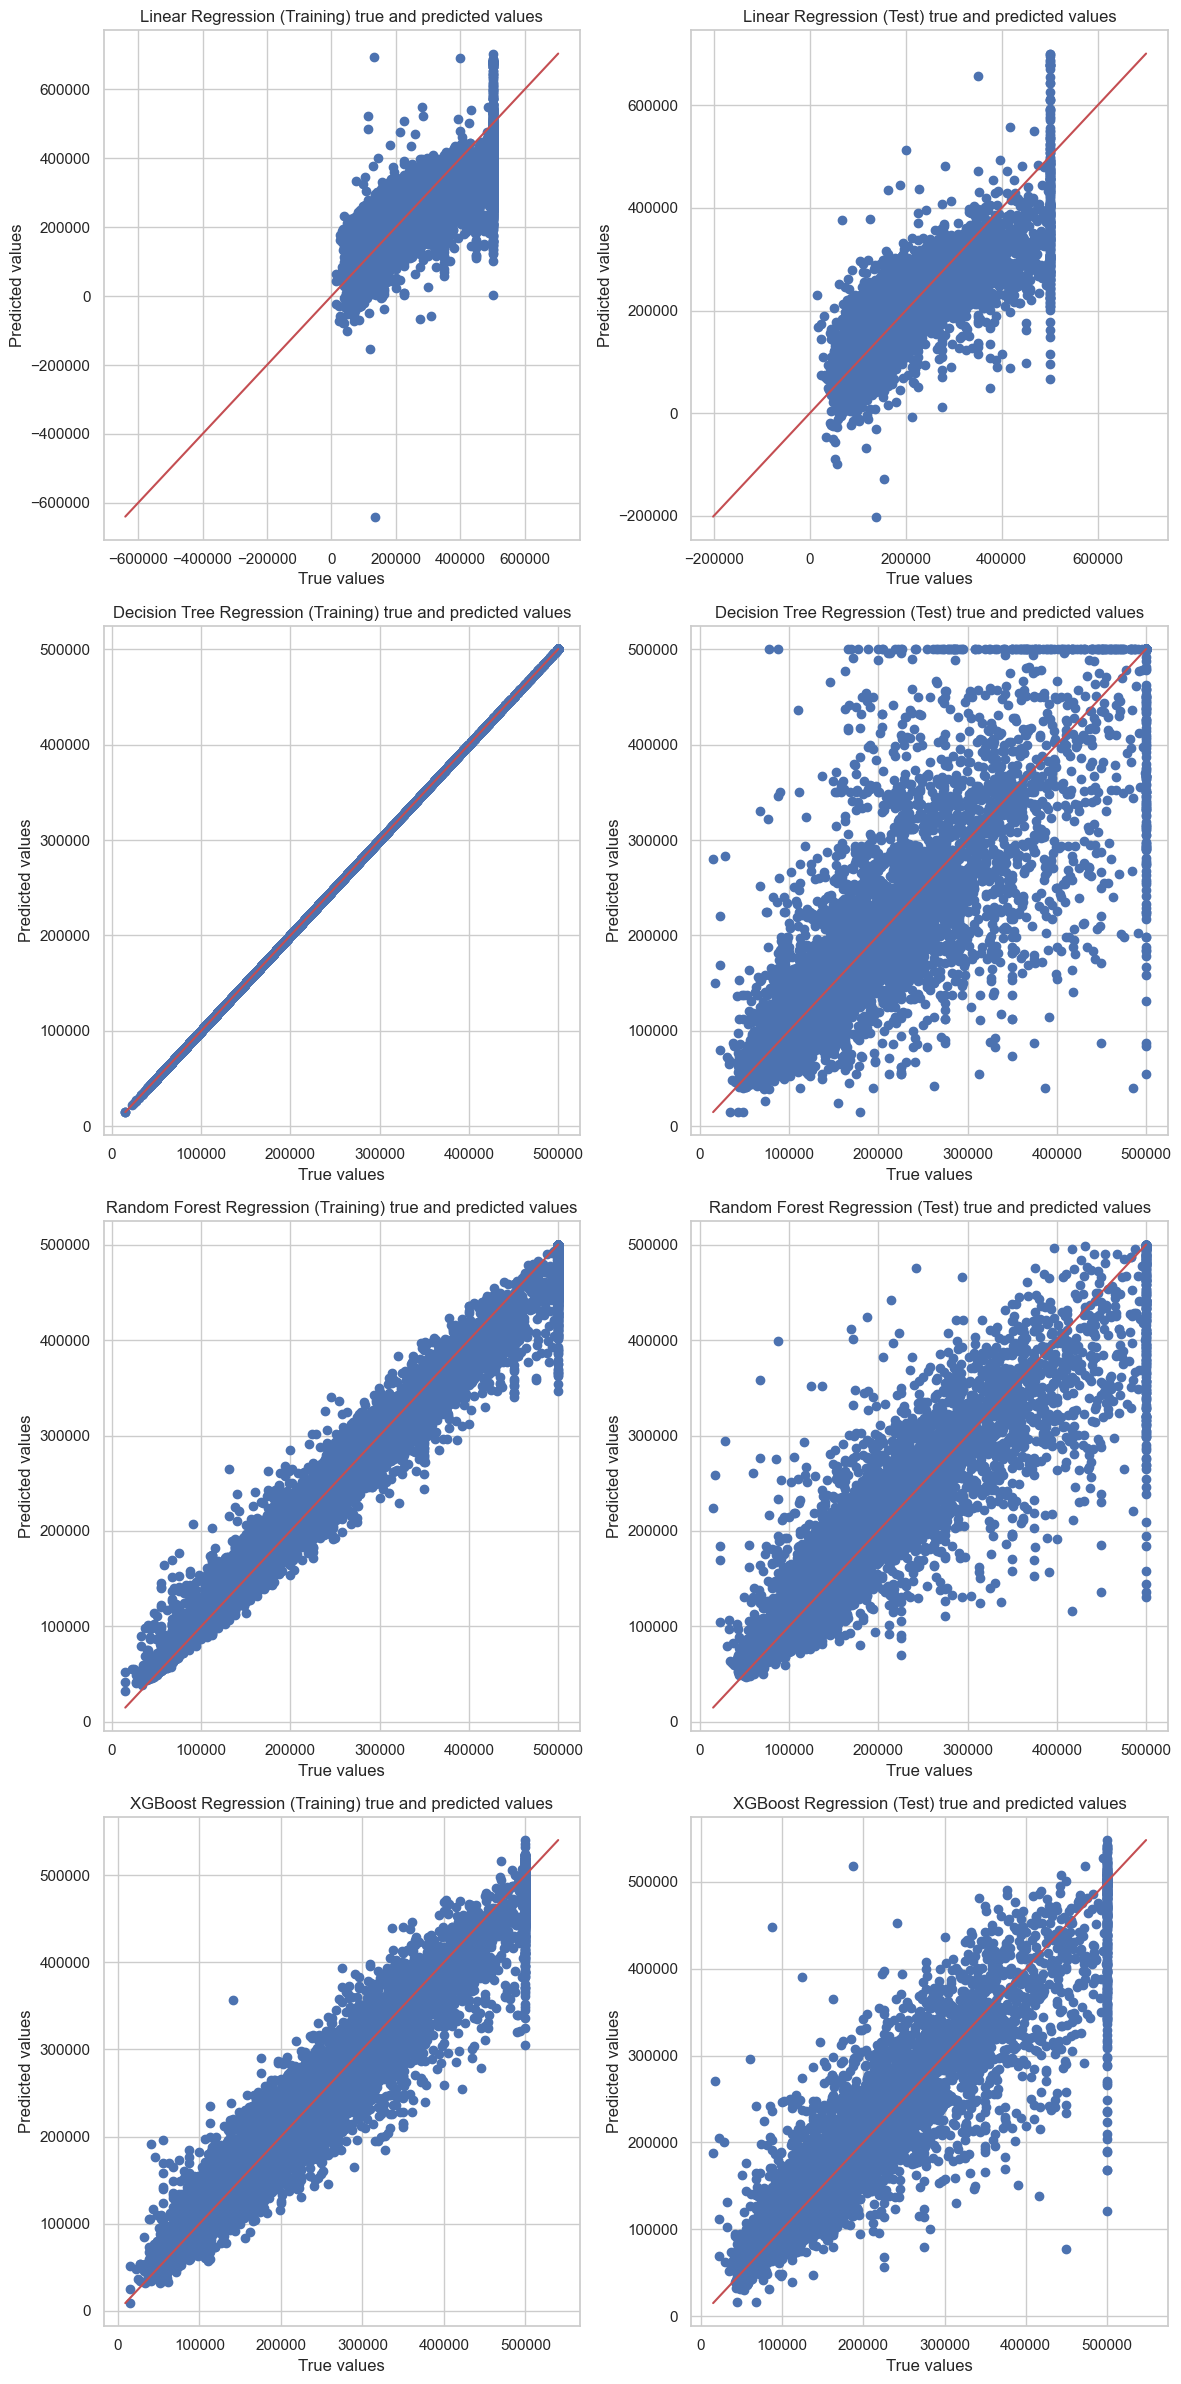

In [22]:
warnings.filterwarnings("ignore", category=FutureWarning)

# let's visualize the predictions
def visualize_predictions(ax, name, y_true, y_pred):
    ax.scatter(x=y_true, y=y_pred)
    min_val = min(np.nanmin(y_true), np.nanmin(y_pred))
    max_val = max(np.nanmax(y_true), np.nanmax(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], color='r')
    ax.set_title(f'{name} true and predicted values')
    ax.set_xlabel('True values')
    ax.set_ylabel('Predicted values')

num_algorithms = len(fitted_models)
fig, axes = plt.subplots(num_algorithms, 2, figsize=(12, 6 * num_algorithms))

for i, (name, model_info) in enumerate(fitted_models.items()):
    model = model_info['model']
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # plotting for training and test sets
    visualize_predictions(axes[i, 0], name + ' (Training)', y_train, y_train_pred)
    visualize_predictions(axes[i, 1], name + ' (Test)', y_test, y_test_pred)

plt.tight_layout()
plt.show()

Now we can interpret the obtained results:
- <b>Linear Regression</b>: has reasonable generalization with a lower <b>MSE</b> on the test set than on the training set, that indicates effective performance; the <b>MAE</b> is within a reasonable range for both sets; also <b>R-squared</b> is 71% which means the percentage of the variance that the model explains about in the test; but there's a notable percentage error on the test set, so there are some limitations.
- <b>Decision Tree Regression</b>: there is an overfitting based on the zero <b>MSE</b> and <b>MAE</b> on the training set; it fails to generalize well to the test set, so there's a high error and a lower <b>R-squared</b> value; this model has perfect fit on the training set, but fail on the unseen data.
- <b>Random Forest Regression</b>: there's a good generalization by the lower <b>MSE</b> on the test set compared to the training set; <b>MAE</b> is moderate for both sets, so it's somewhat accurate; high <b>R-squared</b> value indicates explanation of the significant portion of variance in both training and test sets.
- <b>XGBoost Regression</b>: also shows overfitting based on the lower <b>MSE</b> on the training set but a higher one on the test set; <b>MAE</b> also is low for the training set but higher for the test set; model has perfect fit on the training set, but it's not so good for the test set.

In conclusion, the <b>Random Forest Regression</b> model has the best balance between fitting the training data well and generalizing to new data comparing to other models. Also, the performance of <b>XGBoost Regression</b> model is close to the best one.